In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# Acquisition

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## Loading

### genotype_BXD

In [5]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

In [6]:
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'

In [7]:
print("There is NaN values: %s" % genotype_df.isna().any().any())

There is NaN values: False


In [8]:
np.unique(genotype_df.values, return_counts=True)

(array([-1,  0,  1]), array([349682,  21153, 339593]))

In [9]:
genotype_df.head()

SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BXD_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


<div class="alert alert-block alert-info">
    elements are set to -1, 0, and 1 for the homozygote, heterozygote, and other homozygote (AA, (Aa, aA), aa)
</div>

### Phenotype

In [7]:
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')
phenotype_df.head()

,B6D2F1,D2B6F1,C57BL.6J,DBA.2J,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
PhenoID,,,,,,,,,,,,,,,,,,,,,
X3063,NaN,NaN,1254.090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,707.929,1481.930,NaN,577.571,1971.000,NaN
X3352,NaN,NaN,724.205,NaN,NaN,NaN,NaN,700.643,1304.79,NaN,...,NaN,NaN,NaN,NaN,525.393,765.048,NaN,579.286,691.286,NaN
X1093,NaN,NaN,887.500,507.40,NaN,NaN,NaN,NaN,NaN,NaN,...,366.5,NaN,NaN,NaN,472.640,1060.340,1032.26,646.000,978.000,NaN
X2256,NaN,NaN,607.708,460.07,NaN,NaN,NaN,NaN,NaN,NaN,...,236.4,NaN,NaN,NaN,426.500,788.400,965.60,563.900,1272.400,NaN
X830,NaN,NaN,35444.000,25325.00,NaN,NaN,NaN,NaN,NaN,NaN,...,21515.0,NaN,NaN,NaN,21898.000,38538.000,36348.00,26982.000,39328.000,NaN


In [8]:
phenotype_df.shape

(5092, 97)

In [9]:
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

print("Number of Nan values: %s" % nan_count)
print("Percentage of nan in the phenotype file: {:0.2f}%".format(nan_count / entries_count * 100))

Number of Nan values: 303459
Percentage of nan in the phenotype file: 61.44%


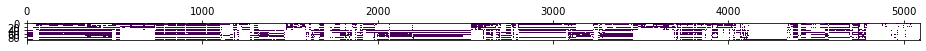

In [10]:
plt.matshow(phenotype_df.T)

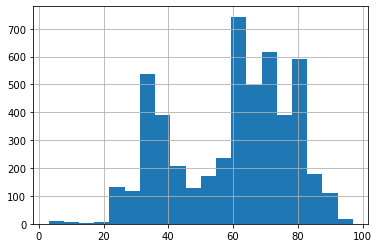

In [11]:
# Let's try finding phenotypes for which the maximum of mice have an entry

phenotype_df.isnull().sum(axis=1).hist(bins=20)

### Protein Expression

EYE.txt seems to be the gene expression with the most 

### Phenotype_id_aligner

In [13]:
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')

In [14]:
phenotype_id_aligner.shape

(5092, 17)

In [17]:
phenotype_id_aligner.columns.tolist()

['PhenoID',
 'PhenoID.1',
 'RecordID',
 'Phenotype',
 'Shown_pheno',
 'Category',
 'Category_ID',
 'color',
 'Phenotype_post',
 'Phenotype_pre',
 'Authors',
 'Senior.Author',
 'Abbreviation',
 'Quantitive.trait',
 'Tissues',
 'Diet',
 'Strains']

In [31]:
phenotype_id_aligner.iloc[0:2]

,PhenoID,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,Quantitive.trait,Tissues,Diet,Strains
0,X3063,3063,12890,"Central nervous system, metabolism, behavior: ...","Activity of 13-week old females, total counts ...",Activity,1.0,1.0,"Central nervous system, metabolism, behavior: ...","Central nervous system, metabolism, behavior: ...","Andreux P, Williams EG, Koutnikova H, Houtkoop...",Auwerx_1,Activity of 13-week old females,Yes,muscle,NaN,19
1,X3352,3352,12960,"Central nervous system, metabolism, behavior: ...","Activity of 13-week old males, total counts of...",Activity,2.0,1.0,"Central nervous system, metabolism, behavior: ...","Central nervous system, metabolism, behavior: ...","Andreux P, Williams EG, Koutnikova H, Houtkoop...",Auwerx_1,Activity of 13-week old males,Yes,muscle,NaN,30


## Cleaning

### Genotype

genotype_df is already clean


In [10]:
genotype_df.to_pickle("data/pickle/genotype.pkl")

## Building graph from features (Preprocessing)

In [13]:
from scipy.spatial.distance import pdist, squareform

### Genotype graph (gene based similarity)

To build our first graph, we chose as nodes the mice and as edges a gene based similarity

In [11]:
genotype_df = pd.read_pickle("data/pickle/genotype.pkl")

In [14]:
strain_genetic_dist = pdist(genotype_df.values, metric='euclidean')

Check the mean pairwise distance  𝔼[𝐷]

In [15]:
from scipy.stats import norm
import scipy
import matplotlib

def hist_norm_fit(serie: pd.Series, ax: matplotlib.axes.Axes, meth: scipy.stats, bins=30):
    """Print a histogram of a given series and fits a normal pdf to it
    
    Args:
        serie: the data series to plot
        ax: the axis to plot on
        bins: the number of bins for the histograms
        meth: name of the pdf to fit to the data (from scipy)
    """
    # Fit a normal distribution to the data:
    if serie.isnull().values.any():
        mu = np.nanmean(serie.values)
        std = np.nanstd(serie.values)
    else:
        mu, std = meth.fit(serie.values)
    

    # Plot the histogram.
    #dataset.Overall.hist(ax = ax,bins = 30)
    ax.hist(serie, bins=bins, density=True, alpha=0.6, color='m')

    # Plot the PDF.
    xt = ax.get_xticks()
    xmin, xmax = np.min(xt),np.max(xt)

    x = np.linspace(xmin, xmax, 100)
    if meth is norm:
        p = meth.pdf(x, mu, std)
    else:
        p = meth.pdf(x)
    ax.plot(x, p, 'k', linewidth=2)
    title = "Fit results to normal: $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
    ax.set_title(title)
    
    

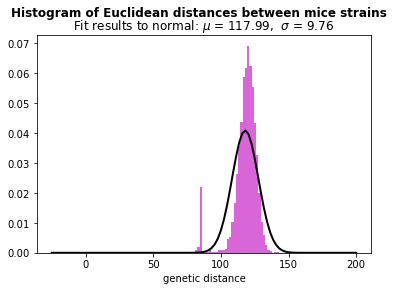

In [16]:

ax = plt.subplot()
plt.suptitle("Histogram of Euclidean distances between mice strains", fontweight='bold')
strain_gen_dist_series = pd.Series(strain_genetic_dist.flatten())
hist_norm_fit(strain_gen_dist_series, ax, meth=norm, bins=100)
ax.set_xlabel("genetic distance")
plt.show()

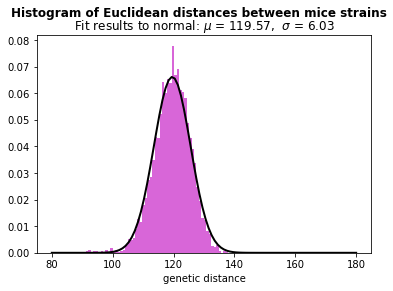

In [17]:
ax = plt.subplot()
plt.suptitle("Histogram of Euclidean distances between mice strains", fontweight='bold')

over90_mask = (strain_gen_dist_series > 90)
hist_norm_fit(strain_gen_dist_series[over90_mask], ax, meth=norm, bins=100)

ax.set_xlabel("genetic distance")
plt.show()

<div class="alert alert-block alert-info">
    Once we mask the peak below 90, the distances genetic distance between strains looks like a gaussian distribution. Still need to investigate where does this ~90 pick comes from.
</div>

In [18]:
# Here we take mean distance value when we don't mask over 90
mean_dist = strain_genetic_dist.mean()
std_dist = strain_genetic_dist.std()
print("Mean pairwise distance: %0.2f (+/- %0.2f)" % (strain_genetic_dist.mean(), strain_genetic_dist.std()))

Mean pairwise distance: 117.99 (+/- 9.76)


Let's create adjacency matrix for the strains by thresholding the Euclidean distance matrix.
The resulting **unweighted** adjacency matrix should have entries


$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$


In [20]:
#Algorithm to create the edges
threshold = mean_dist
gen_related_strain_A = squareform(strain_genetic_dist).copy()
gen_related_strain_A[gen_related_strain_A < threshold] = 1
gen_related_strain_A[gen_related_strain_A >= threshold] = 0
gen_related_strain_A -= np.identity(gen_related_strain_A.shape[0])
gen_related_strain_A.shape

(97, 97)

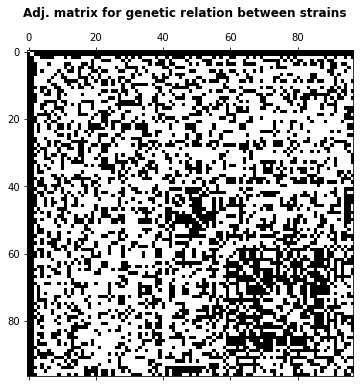

In [21]:
plt.figure(figsize=(6, 6))
plt.spy(gen_related_strain_A)
plt.suptitle("Adj. matrix for genetic relation between strains", fontweight='bold')
plt.show()

In [ ]:
np.save("data/numpy/gen_related_strain_A.npy", gen_related_strain_A)

# Exploration

## Gene graph

### Distribution

In [23]:
A_genes = np.load("data/numpy/gen_related_strain_A.npy")

In [24]:
gene_graph = nx.from_numpy_array(A_genes)

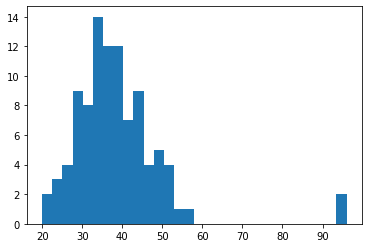

In [48]:
def plot_hist(G, bins=30):
    d = G.degree()
    plt.hist(list(dict(d).values()), bins=bins)
    plt.show()
    
plot_hist(gene_graph)

### Connected components

In [50]:
print("Number of connected components: %i" %nx.number_connected_components(gene_graph))

Number of connected components: 1


### Diameter

In [52]:
print("The diameter of the network (longest shortest path) is: %i" % nx.diameter(gene_graph))

The diameter of the network (longest shortest path) is: 2


# Exploitation